In [1]:
import torch
import random
import torch.nn as nn
import torch.utils.data as data
from torch.autograd import grad
from torch.autograd.functional import hessian
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple
from tqdm import tqdm
from torch.optim import Adam, SGD, LBFGS
from src.nonconvex import sgd, create_proj_fn, create_loss_fn
from src.utils import extract_measurement, create_P, PSSE_initialization, same_seed
from src.search import create_search_loss_fn, create_search_proj_fn, search
from src.verify import check_PSSE

In [2]:
p1_r = np.array([
    [1.0, 0.0],
    [0.0, 0.0]
])
p1_i = np.array([
    [0.0, 0.0],
    [0.0, 0.0]
])
p2_r = np.array([
    [0, -50/101],
    [-50/101, 100/101]
])
p2_i = np.array([
    [0, -500/101],
    [500/101, 0]
])
p3_r = np.array([
    [0, -50/101],
    [50/101, 0]
])
p3_i = np.array([
    [0, -500/101],
    [-500/101, 1000/101]
])
p4_r = np.array([
    [100/101, -50/101],
    [-50/101, 0]
])
p4_i = np.array([
    [0, 500/101],
    [-500/101, 0]
])
bus2_mats = [(p1_r, p1_i, True), (p2_r, p2_i, True), (p3_r, p3_i, False), (p4_r, p4_i, True)]

In [3]:
def plot_loss(losses):
    fig, ax = plt.subplots(3, 2, figsize=(20, 30), tight_layout=True)
    loss    = [loss[0] for loss in losses]
    diff    = [-loss[1] for loss in losses]
    grad_X  = [loss[2] for loss in losses]
    hess_X  = [loss[3] for loss in losses]
    f_X     = [loss[4] for loss in losses]
    f_Z     = [loss[5] for loss in losses]
    trans   = [loss[6] for loss in losses]
    
    ax[0][0].plot(loss)
    ax[0][1].plot(diff)
    ax[1][0].plot(grad_X)
    ax[1][1].plot(trans)
    ax[2][0].plot(hess_X)
    ax[2][1].plot(f_X, label=r'f(X)')
    ax[2][1].plot(f_Z, label=r'f(Z)')

    ax[0][0].set_xlabel("# of GD Updates", fontsize=30), 
    ax[0][0].set_ylabel(r"$g(X,Z,E)$", fontsize=30)
    ax[0][0].set_title(f"Total Loss vs. # of GD Updates", fontsize=25, fontname='Comic Sans MS')
    ax[0][0].xaxis.set_tick_params(labelsize=20)
    ax[0][0].yaxis.set_tick_params(labelsize=20)
    ax[0][0].set_yscale('log')
    ax[0][0].grid()

    ax[0][1].set_xlabel("# of GD Updates", fontsize=30), 
    ax[0][1].set_ylabel(r"$f(X)-f(Z)$", fontsize=30)
    ax[0][1].set_title(r"$f(X)-f(Z)$ vs. # of GD Updates", fontsize=25, fontname='Comic Sans MS')
    ax[0][1].xaxis.set_tick_params(labelsize=20)
    ax[0][1].yaxis.set_tick_params(labelsize=20)
    ax[0][1].set_yscale('log')
    ax[0][1].grid()

    ax[1][0].set_xlabel("# of GD Updates", fontsize=30), 
    ax[1][0].set_ylabel(r"$\|\nabla_Xf(X)\|_F$", fontsize=30)
    ax[1][0].set_title(r"$\|\nabla_Xf(X)\|_F$ vs. # of GD Updates", fontsize=25, fontname='Comic Sans MS')
    ax[1][0].xaxis.set_tick_params(labelsize=20)
    ax[1][0].yaxis.set_tick_params(labelsize=20)
    ax[1][0].set_yscale('log')
    ax[1][0].grid()

    ax[1][1].set_xlabel("# of GD Updates", fontsize=30), 
    ax[1][1].set_ylabel(r"$-\|X-Z\|_2^2$", fontsize=30)
    ax[1][1].set_title(r"$-\|X-Z\|_2^2$ vs. # of GD Updates", fontsize=25, fontname='Comic Sans MS')
    ax[1][1].xaxis.set_tick_params(labelsize=20)
    ax[1][1].yaxis.set_tick_params(labelsize=20)
    ax[1][1].grid()

    ax[2][0].set_xlabel("# of GD Updates", fontsize=30), 
    ax[2][0].set_ylabel(r"$-\lambda_{min}(\nabla^2_Xf(X))$", fontsize=30)
    ax[2][0].set_title(r"$-\lambda_{min}(\nabla^2_Xf(X))$ vs. # of GD Updates", fontsize=25, fontname='Comic Sans MS')
    ax[2][0].xaxis.set_tick_params(labelsize=20)
    ax[2][0].yaxis.set_tick_params(labelsize=20)
    ax[2][0].set_yscale('log')
    ax[2][0].grid()

    ax[2][1].set_xlabel("# of GD Updates", fontsize=30), 
    ax[2][1].set_ylabel("Function Value", fontsize=30)
    ax[2][1].set_title("Function Value vs. # of GD Updates", fontsize=25, fontname='Comic Sans MS')
    ax[2][1].xaxis.set_tick_params(labelsize=20)
    ax[2][1].yaxis.set_tick_params(labelsize=20)
    # ax[2][1].set_yscale('log')
    ax[2][1].legend(loc='best')
    ax[2][1].set_yscale('log')
    ax[2][1].grid()

In [4]:
def search_counter(N, e_norm, Mats, z=None, loss_type='PSSE_max', optim='Adam', iters=100, lr=0.001, min_lr=5e-5, lr_sched='cosine', T=1, trans_bound=(-1, -1e-2)):
    P = create_P(Mats)[:N]
    # x_0 = PSSE_initialization(z, 1.0)
    # x = torch.tensor(np.concatenate([x_0.real, x_0.imag]), requires_grad=True, dtype=torch.float64)
    
    if z is not None:
        z_default = torch.tensor(np.concatenate([z.real, z.imag]), dtype=torch.float64)
        gaussian_vector = torch.normal(0, torch.ones(z_default.size())).to(torch.float64)
        x = gaussian_vector / torch.linalg.norm(gaussian_vector, ord=torch.inf)
        e = torch.zeros(len(P), requires_grad=True, dtype=torch.float64)
        x.requires_grad_()
        parameters = [x, e]
        
    else:
        z_default = 0
        x = torch.normal(0.0, torch.ones((P[0].size(0)),1)).to(torch.float64)
        z = torch.normal(0.0, torch.ones((P[0].size(0)),1)).to(torch.float64)
        e = torch.zeros(len(P), requires_grad=True, dtype=torch.float64)
        x.requires_grad_()
        z.requires_grad_()
        parameters = [x, e, z]
    
    loss_fn = create_loss_fn('PSSE', P=P, Z=z_default, ZL=0, ZR=0, e=0)
    criterion = create_search_loss_fn(loss_fn, loss_type, Z=z_default, e=0)
    proj_fn = create_search_proj_fn('PSSE', max_norm=e_norm)
    proj_fn(*parameters)
    # print(parameters[0].is_leaf, parameters[1].is_leaf)
    losses = search(
        parameters,
        criterion,
        proj_fn,
        optim,
        iters,
        lr,
        min_lr,
        lr_sched,
        T,
        trans_bound
    )

    # z_rect.requires_grad_(True)
    # z_rect_n = torch.tensor(-np.concatenate([z.real, z.imag]), requires_grad=True, dtype=torch.float64).to(device)
    # print(torch.linalg.matrix_norm(grad(loss_fn(parameters[0], parameters[-1]), parameters[0])[0]).item())
    # print(torch.linalg.matrix_norm(grad(loss_fn(z_rect, parameters[-1]), z_rect)[0]).item())
    # print(torch.linalg.matrix_norm(grad(loss_fn(z_rect_n, parameters[-1]), z_rect_n)[0]).item())
    return parameters, z_default, P, losses

tensor([[ 0.5059],
        [-0.3002],
        [ 0.0000],
        [ 0.5905]], dtype=torch.float64, requires_grad=True)
tensor([[-1.1696],
        [-0.6356],
        [ 0.0000],
        [-0.2994]], dtype=torch.float64, requires_grad=True)
tensor([-5.7735e-19, -5.7735e-19, -5.7735e-19], dtype=torch.float64,
       requires_grad=True)


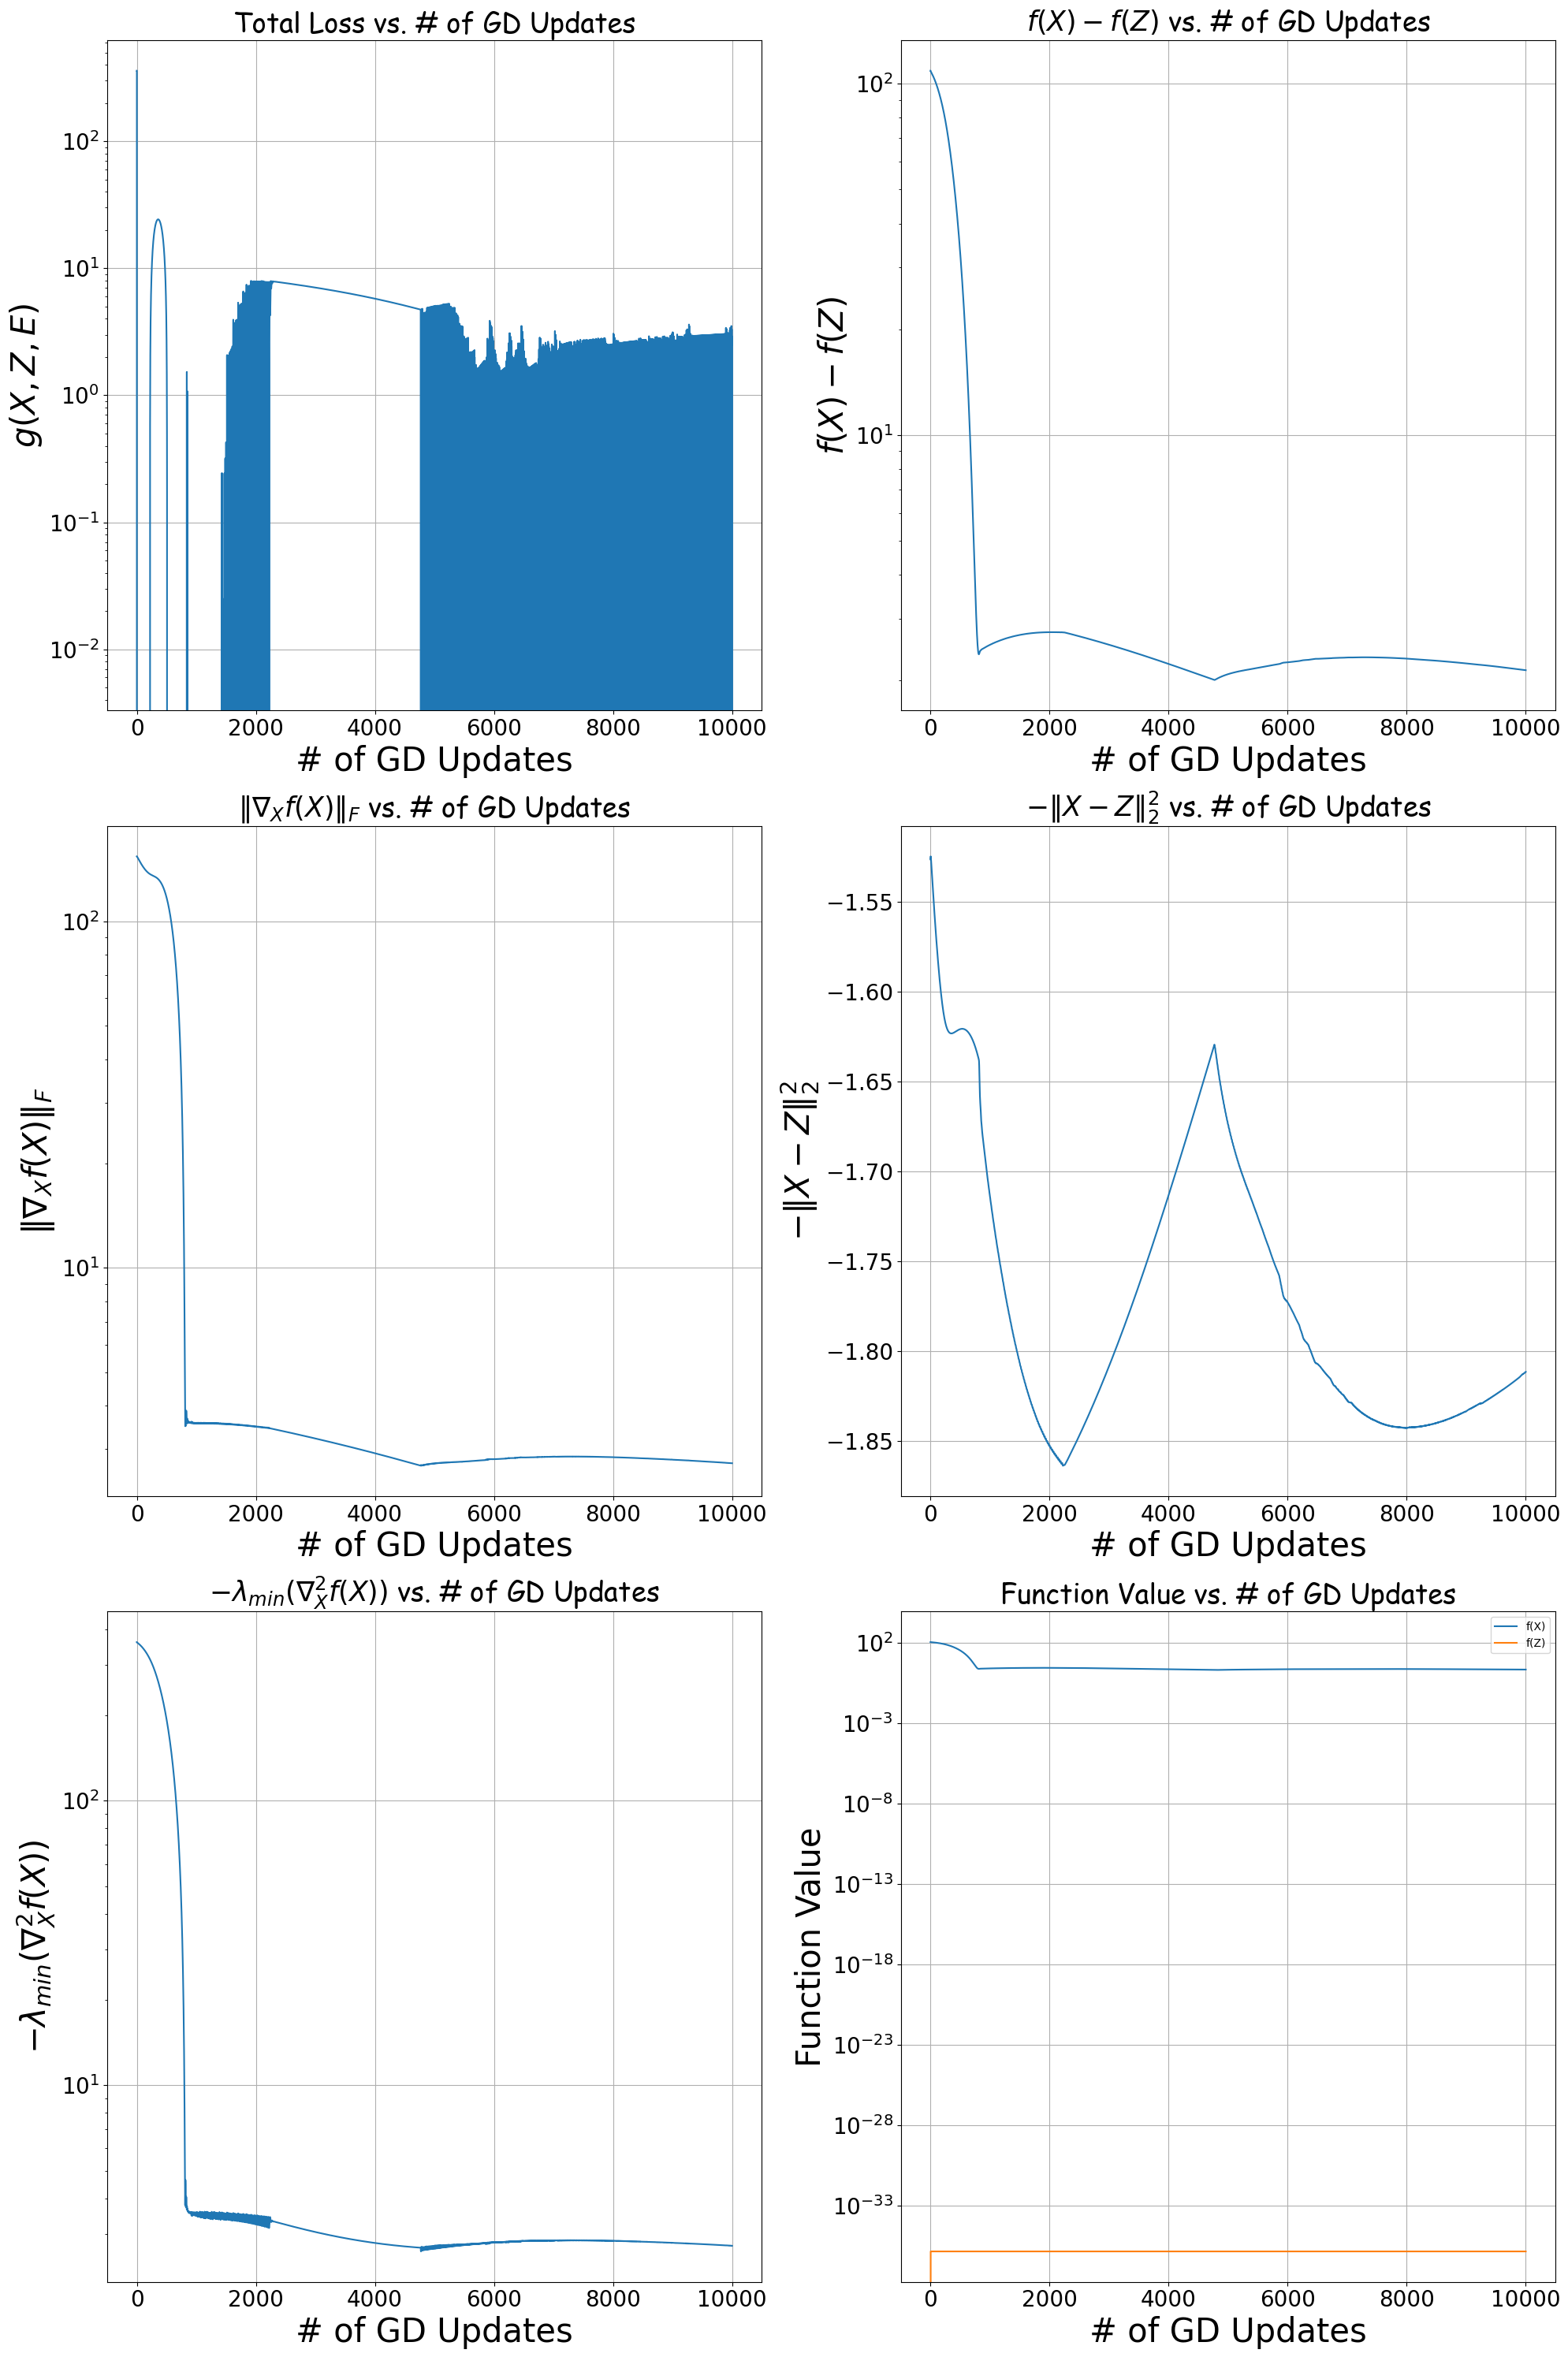

In [6]:
####### 2-bus Example #######
N           = 3        # 3 ~ 6
e_norm      = 1e-18 
device      = 'cuda:0' if torch.cuda.is_available() else 'cpu'
coeff       = torch.tensor([10.0, 10.0], requires_grad=True)
loss_type   = 'PSSE_max'
optim       = 'Adam'
iters       = 10000
lr          = 3e-4
min_lr      = 5e-5
lr_sched    = 'cosine'
T           = 1.5
trans_bound = (-1, -5e1)

same_seed(42)
# z = torch.tensor([1, 0.8071, 0, -0.1893]).unsqueeze(-1)
parameters, z_rect, P, losses = search_counter(
    N, 
    e_norm, 
    bus2_mats,
    None,
    loss_type, 
    optim, 
    iters, 
    lr, 
    min_lr,
    lr_sched, 
    T,
    trans_bound
)
x, e, z = parameters[0], parameters[1], parameters[2]
print(x)
print(z)
print(e)
plot_loss(losses)

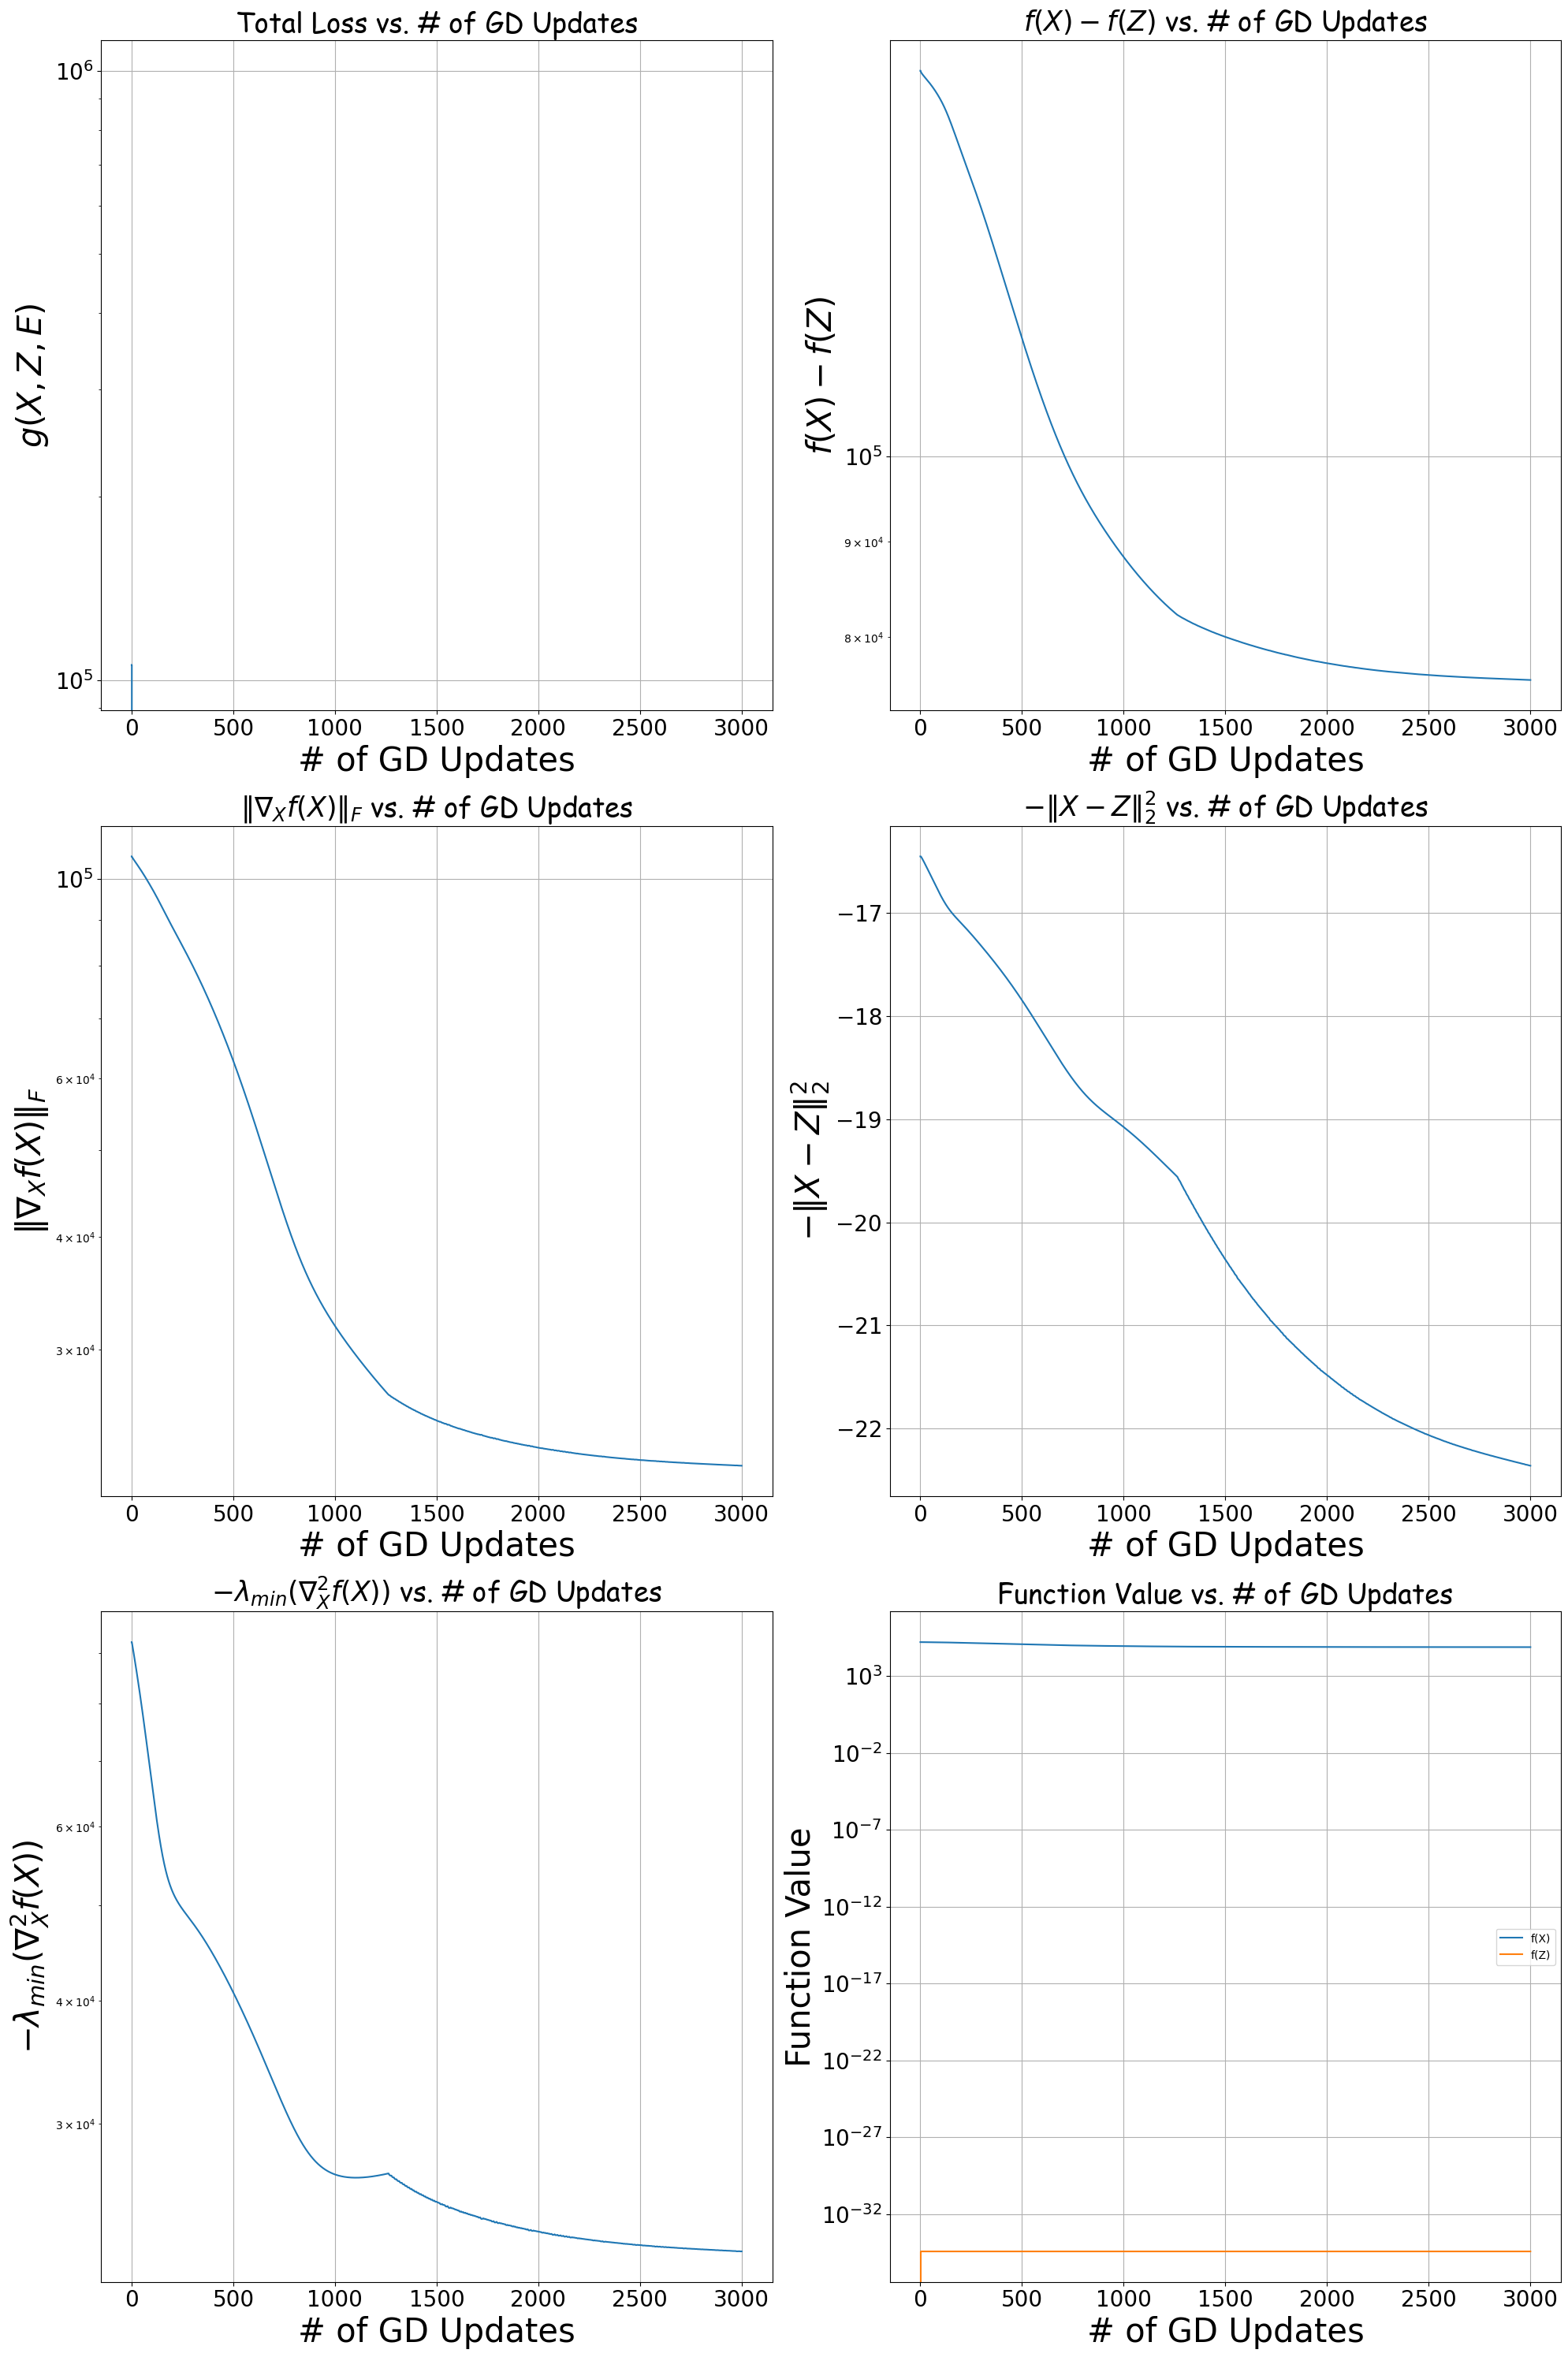

In [7]:
####### 14-bus example #######
N           = 75        # 28 ~ 122
e_norm      = 1e-18 
device      = 'cuda:0' if torch.cuda.is_available() else 'cpu'
coeff       = torch.tensor([10.0, 10.0], requires_grad=True)
loss_type   = 'PSSE_max'
optim       = 'AdamW'
iters       = 3000
lr          = 5e-4
min_lr      = 5e-5
lr_sched    = 'cosine'
T           = 1
trans_bound = (-1, -5e1)

same_seed(42)
Mats, z = extract_measurement() # Extract the measurement matrix and the ground truth voltages
parameters, z_rect, P, losses = search_counter(
    N, 
    e_norm, 
    Mats,
    z,
    loss_type, 
    optim, 
    iters, 
    lr, 
    min_lr,
    lr_sched, 
    T,
    trans_bound
)
x, e = parameters[0], parameters[1]
# print(x)
# print(z)
# print(e)
plot_loss(losses)

In [8]:
def DSE(N, search_loops, e_norm, loss_type='PSSE_max', optim='Adam', iters=100, lr=0.001, min_lr=5e-5, lr_sched='cosine', T=1, trans_bound=(-1, -1e2)):
    same_seed(0)
    for i in range(search_loops):
        Mats, z = extract_measurement()
        parameters, z_rect, P, losses = search_counter(
            N, 
            e_norm, 
            Mats,
            z,
            loss_type, 
            optim, 
            iters, 
            lr, 
            min_lr,
            lr_sched, 
            T,
            trans_bound
        )
        if i == 0:
            print(z_rect.data)
        if len(losses) < iters + 1:
            continue
        flag = check_PSSE(parameters[0], P, z_rect)
        if flag:
            print(f"(TT_loss, diff, grad_X, hess_X, trans) = ({losses[-1][0]:.2e},{losses[-1][1]:.2e},{losses[-1][2]:.2e},{losses[-1][3]:.2e},{losses[-1][6]:.2e})")
            print(f"{parameters[0].data}")
            print(f"Error norm = {torch.linalg.norm(parameters[0] - z_rect, ord='fro')}")


In [9]:
N           = 75        # 28 ~ 122
e_norm      = 1e-18 
# device      = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# coeff       = torch.tensor([10.0, 10.0], requires_grad=True)
loss_type   = 'PSSE_max'
optim       = 'AdamW'
iters       = 10000
lr          = 5e-4
min_lr      = 5e-5
lr_sched    = 'cosine'
T           = 4
trans_bound = (-1, -5e1)

search_loops = 10

DSE(N, search_loops, e_norm, loss_type, optim, iters, lr, min_lr, lr_sched, T, trans_bound)

KeyboardInterrupt: 

In [4]:
def generate_data(t_res, N_res, repeat=4, iters=10000, lr=0.0001, lr_sched='static', optim='SGD', device='cpu'):
    proj_fn = create_proj_fn('PSSE')
    Mats, z = extract_measurement()
    n = z.shape[0] * 2 - 1
    m = len(Mats)
    P = create_P(Mats)
    z_rect = torch.tensor(np.concatenate([z.real, z.imag]), dtype=torch.float64)
    
    x_axis = np.arange(0.1, 1, t_res)
    y_axis = np.arange(n, m, N_res)
    grad_norms, success = np.zeros((len(x_axis), len(y_axis), repeat)), np.zeros((len(x_axis), len(y_axis), repeat))
    for i, t in enumerate(x_axis):
        for j, N in enumerate(y_axis):
            for rep in range(repeat):
                criterion = create_loss_fn('PSSE_1', P=P[:N], z=z_rect)
                x_0 = PSSE_initialization(z, t)
                x_rect = torch.tensor(np.concatenate([x_0.real, x_0.imag]), requires_grad=True, dtype=torch.float64).to(device)
                proj_fn(x_rect)
                parameters = [x_rect]
                _, grad_norm, _ = sgd(
                    parameters, 
                    criterion,
                    proj_fn,
                    optim, 
                    iters, 
                    lr,
                    lr_sched,
                )
                error_norm = torch.linalg.norm(parameters[0].detach() - z_rect, ord='fro')
                # print(t, N, error_norm)
                if error_norm < 1e-9:
                    success[i][j][rep] += 1
                grad_norms[i][j][rep] += grad_norm
    
    avg_grad_norm = np.average(grad_norms, axis=-1)
    success_rate = np.average(success, axis=-1)

    return x_axis, y_axis, avg_grad_norm, success_rate 
    

In [5]:
def plot_color(x_axis, y_axis, avg_grad_norm, success_rate):
    fig, ax = plt.subplots(1, 2, figsize=(20, 10), tight_layout=True)
    print(success_rate.shape)
    print(x_axis.shape)
    print(y_axis.shape)
    X, Y = np.meshgrid(x_axis, y_axis)
    pcm = ax[0].pcolormesh(X, Y, success_rate.T, cmap='viridis', shading='nearest')
    fig.colorbar(pcm, ax=ax[0], label='Z-value')

In [6]:
t_res       = 0.1
N_res       = 10
repeat      = 4
iters       = 30000
lr          = 0.0002
lr_sched    = 'cosine'
optim       = 'SGD'
device      = 'cuda:0' if torch.cuda.is_available() else 'cpu'

x_axis, y_axis, avg_grad_norm , sucess_rate = generate_data(t_res, N_res, repeat, iters, lr, lr_sched, optim, device)

Iter: 21869, lr=0.000034, loss=0.000000000:  73%|███████▎  | 21870/30000 [16:25<00:09, 844.69it/s] 

In [ ]:
print(sucess_rate)
plot_color(x_axis, y_axis, avg_grad_norm, sucess_rate)